## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import missingno as msno

## Load Data

In [2]:
url = "https://github.com/WiraDKP/supervised_learning/blob/master/04%20-%20KNN%20%26%20Scikit-learn/data/titanic.csv?raw=true"
data = pd.read_csv(url, index_col="PassengerId")
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Cek Missing Value

<Axes: >

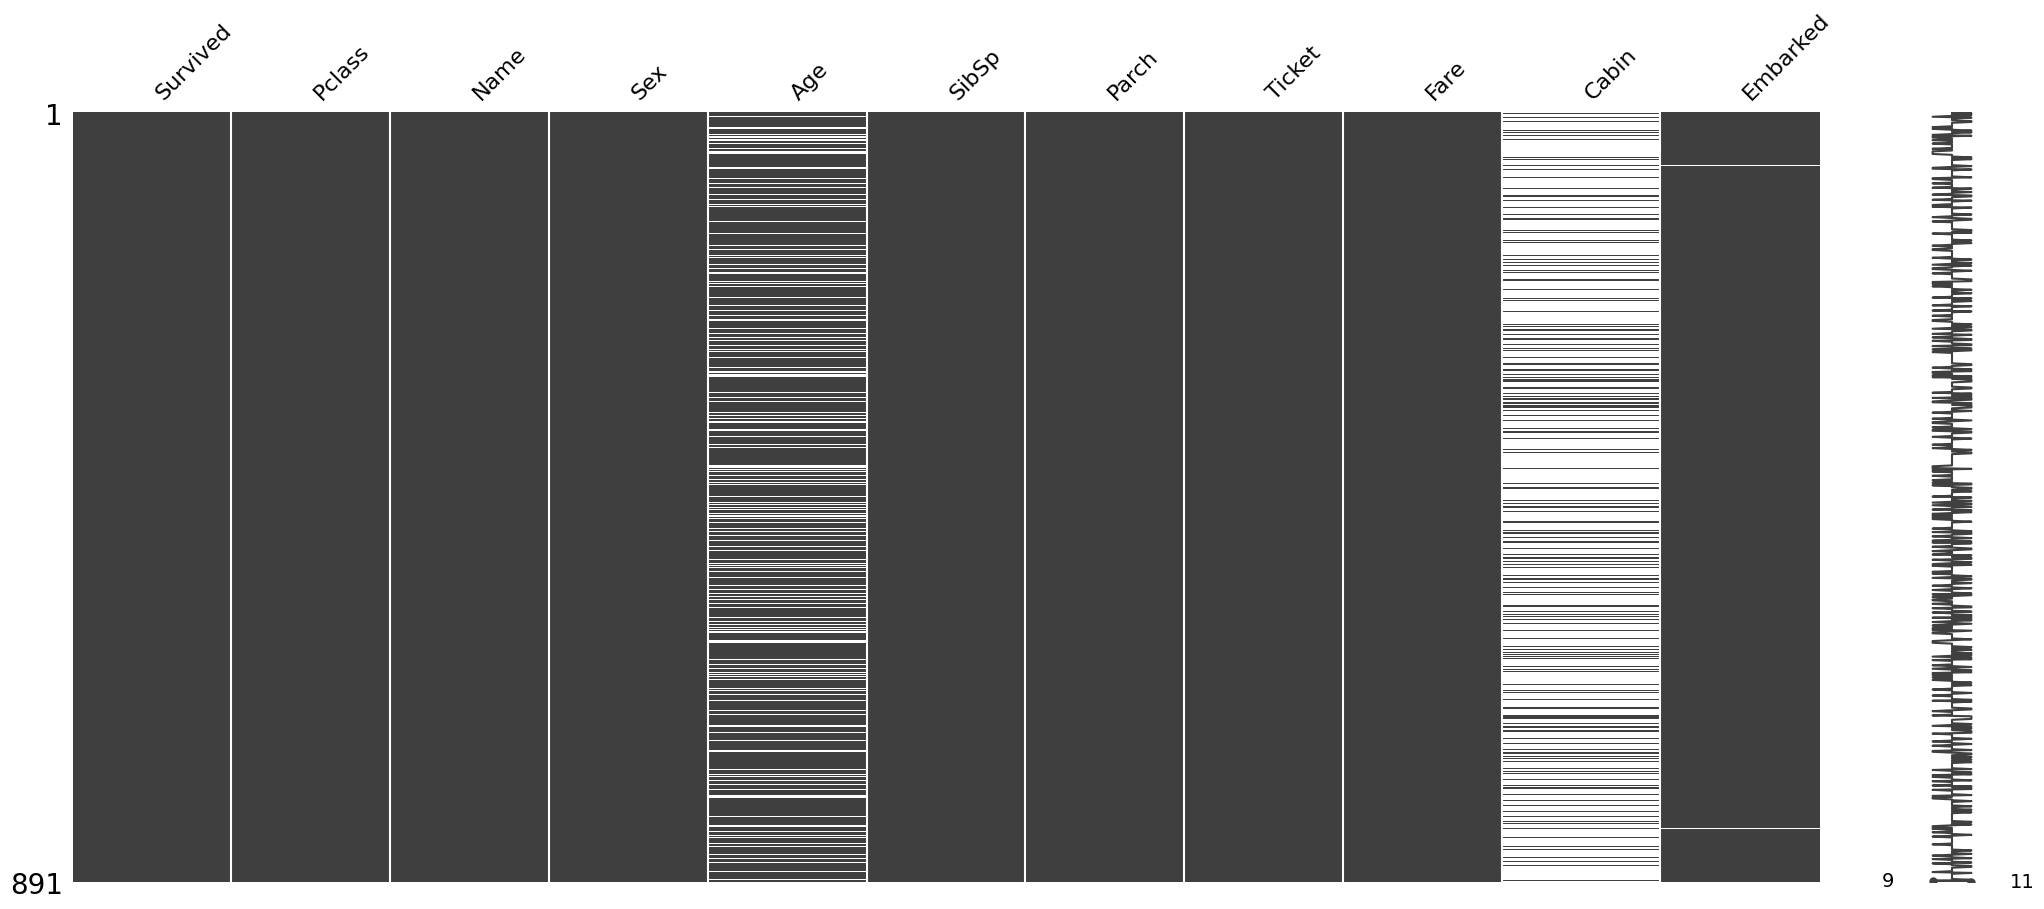

In [3]:
msno.matrix(data)

## Drop Kolom

In [4]:
data.drop(columns=['Name', 'Ticket', 'Cabin', 'Age'], inplace=True)
data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,0,3,male,1,0,7.2500,S
2,1,1,female,1,0,71.2833,C
3,1,3,female,0,0,7.9250,S
4,1,1,female,1,0,53.1000,S
5,0,3,male,0,0,8.0500,S


## Feature Associations

In [5]:
!pip install dython

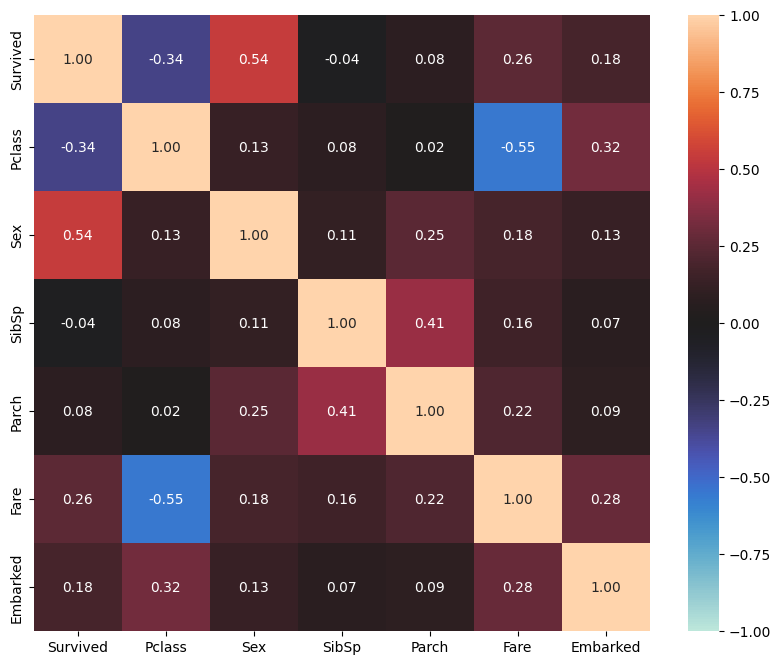

In [6]:
from dython.nominal import associations
import matplotlib.pyplot as plt

association_matrix = associations(data, nom_nom_assoc='cramer', figsize=(10, 8))

plt.show()

## Split Data

In [7]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Survived'])
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 6), (179, 6), (712,), (179,))

## Training

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import PowerTransformer
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), ['SibSp', 'Parch', 'Fare']),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ['Pclass', 'Sex', 'Embarked'])
    ]
)

parameter = {
    'algo__n_neighbors': randint(3, 10),
    'algo__weights': ['uniform', 'distance'],
    'algo__algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'algo__leaf_size': randint(10, 50),
    'algo__p': [1, 2],
}

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

In [9]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['SibSp',
                                                                                'Parch',
                                                                                'Fare']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Pclass'...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__algorithm': ['auto', 'ball_tree',
                                                            'kd_tree'],
                                        'algo__leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b09aebd4750>,
                                        'algo__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b09aecf42d0>,
                                        'algo__p': [1, 2],
                                        'algo__weights': ['uniform',
                                                          'distance']},
                   random_state=42, verbose=1)

In [10]:
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__algorithm': 'kd_tree', 'algo__leaf_size': 49, 'algo__n_neighbors': 8, 'algo__p': 1, 'algo__weights': 'uniform'}
0.8412921348314607 0.8061908307626848 0.7988826815642458


## Evaluasi Model

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}\n")

print("**Evaluasi pada Data Test**")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

Jumlah data train: 712
Jumlah data test: 179

**Evaluasi pada Data Train**
Akurasi: 0.8413
Precision: 0.8457
Recall: 0.8413
F1-Score: 0.8365

**Evaluasi pada Data Test**
Akurasi: 0.7989
Precision: 0.8005
Recall: 0.7989
F1-Score: 0.7925


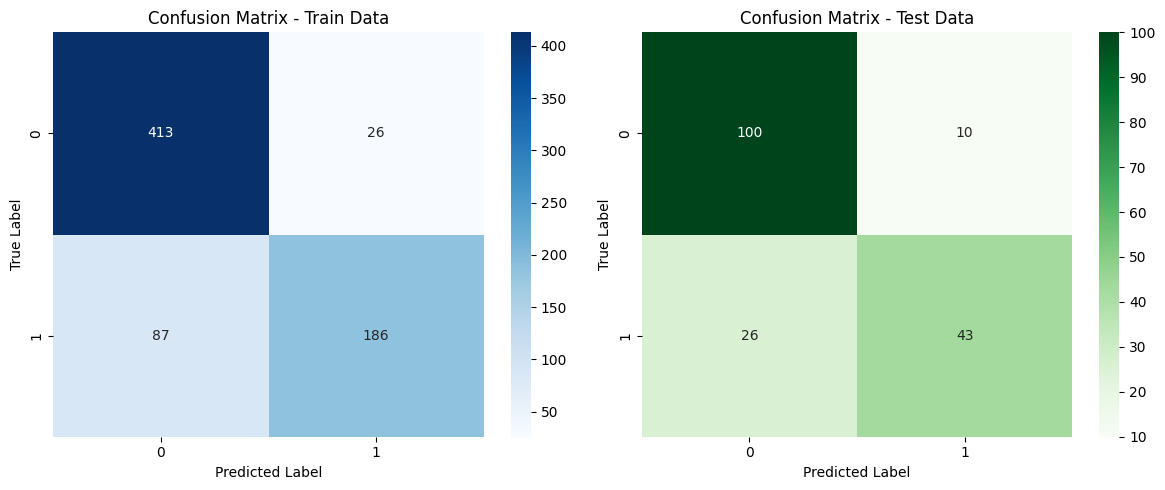

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Data")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Data")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Classification Report - Train Data:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report - Train Data:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       439
           1       0.88      0.68      0.77       273

    accuracy                           0.84       712
   macro avg       0.85      0.81      0.82       712
weighted avg       0.85      0.84      0.84       712


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       110
           1       0.81      0.62      0.70        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179



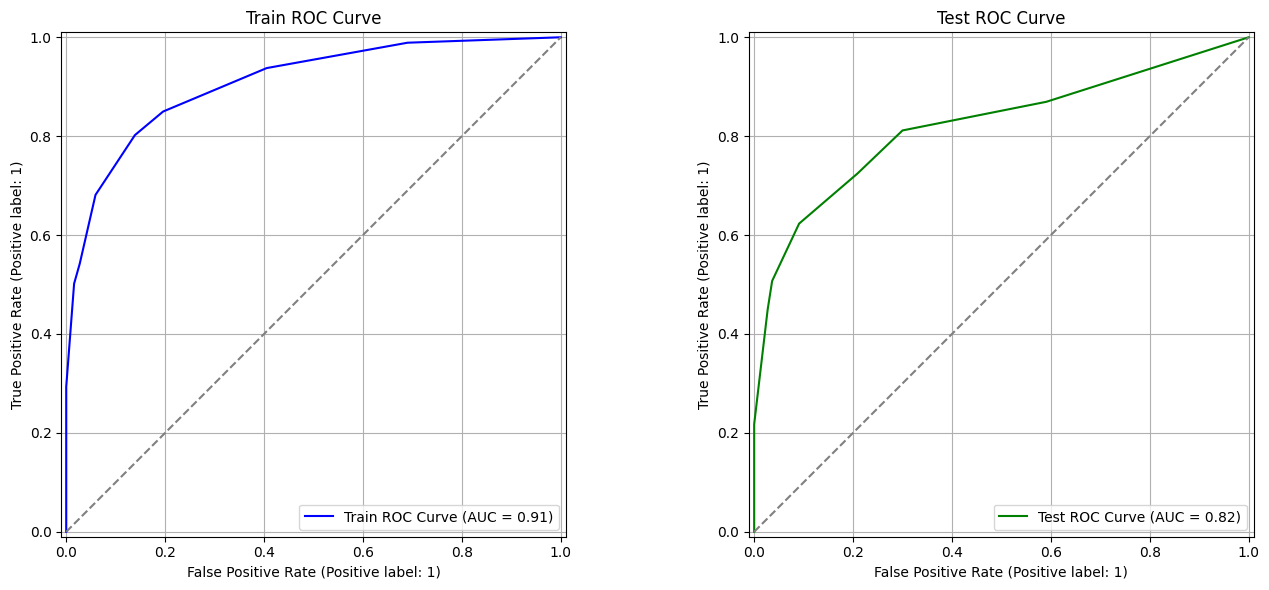

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

RocCurveDisplay.from_estimator(
    model, X_train, y_train, ax=axes[0], name="Train ROC Curve", color="blue"
)
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_title("Train ROC Curve")
axes[0].grid()

RocCurveDisplay.from_estimator(
    model, X_test, y_test, ax=axes[1], name="Test ROC Curve", color="green"
)
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("Test ROC Curve")
axes[1].grid()

plt.tight_layout()
plt.show()

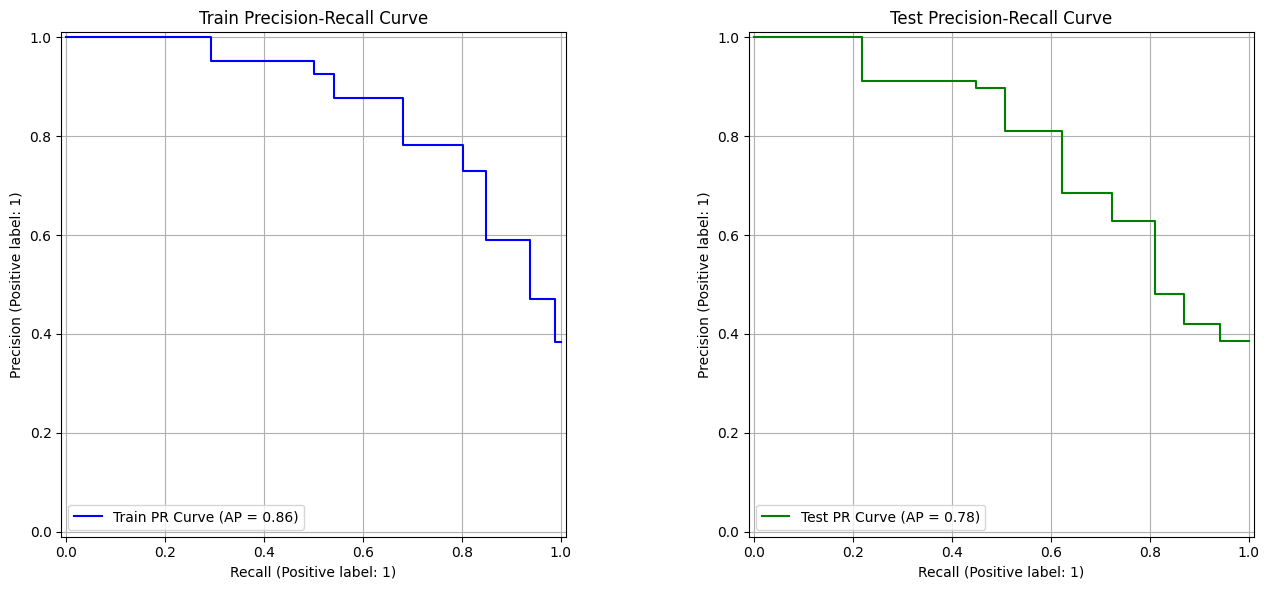

In [15]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    model, X_train, y_train, ax=axes[0], name="Train PR Curve", color="blue"
)
axes[0].set_title("Train Precision-Recall Curve")
axes[0].grid()

PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, ax=axes[1], name="Test PR Curve", color="green"
)
axes[1].set_title("Test Precision-Recall Curve")
axes[1].grid()

plt.tight_layout()
plt.show()

## Feature Importance

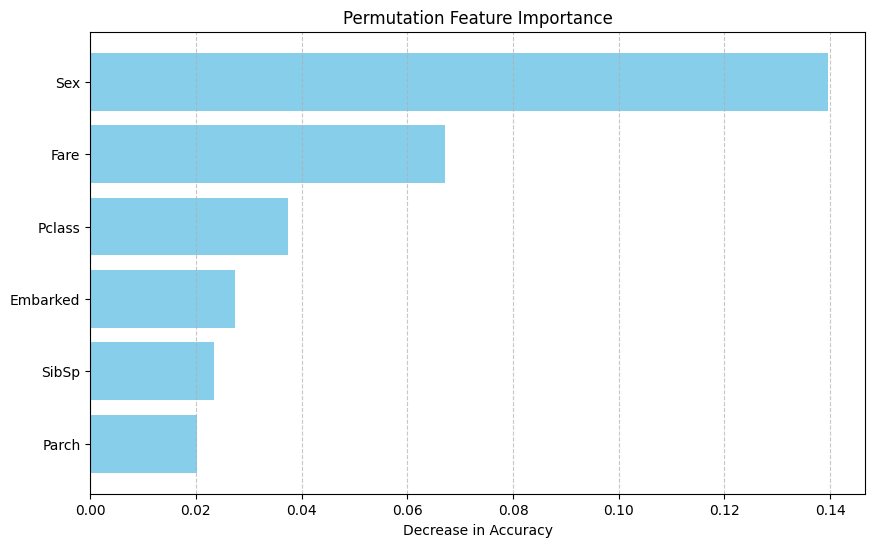

In [20]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.title('Permutation Feature Importance')
plt.xlabel('Decrease in Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Prediksi

In [21]:
X_train.iloc[1]

,482
Pclass,2
Sex,male
SibSp,0
Parch,0
Fare,0.0
Embarked,S


In [ ]:
data = [
    [1, "female", 1, 1, 80, "S"],
    [3, "male", 0, 0, 5, "S"]
]

X_pred = pd.DataFrame(data, index=["Rose", "Jack"], columns=X.columns)

X_pred["Survived"] = model.predict(X_pred)

X_pred

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Survived
Rose,1,female,1,1,80,S,1
Jack,3,male,0,0,5,S,0


In [22]:
import pickle

best_pipeline = model.best_estimator_
with open("titanic.pkl", "wb") as file:
    pickle.dump(best_pipeline, file)

In [26]:
import pickle

with open("titanic.pkl", "rb") as file:
    titanic = pickle.load(file)

In [23]:
X_train.iloc[1]

,482
Pclass,2
Sex,male
SibSp,0
Parch,0
Fare,0.0
Embarked,S


In [29]:
new_data = pd.DataFrame({
    'Pclass': [1, 3],
    'Sex': ["female", "male"],
    'SibSp': [1, 0],
    'Parch': [1, 0],
    'Fare': [80, 5],
    'Embarked': ["S", "S"]
}, index=["Rose", "Jack"])

new_data['Predict'] = titanic.predict(new_data)
new_data

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Predict
Rose,1,female,1,1,80,S,1
Jack,3,male,0,0,5,S,0


In [33]:
data['Embarked'].unique()
data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [34]:
data['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [35]:
data['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

In [37]:
data['Pclass'].unique()

array([3, 1, 2])